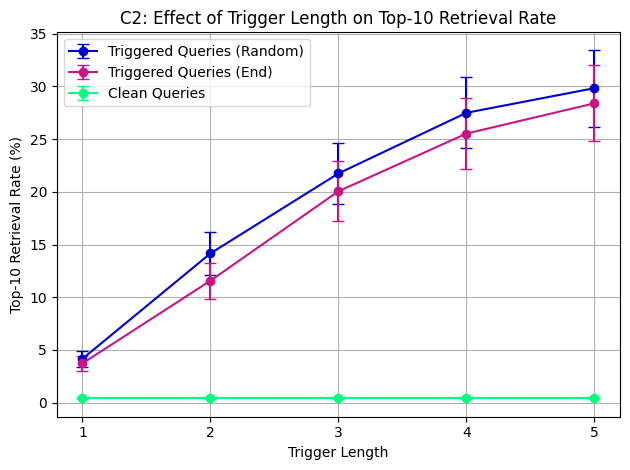

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results
df_random = pd.read_csv("../results/c2_26_7_random.tsv", sep="\t").rename(columns={"trigger_length": "length"})
df_end = pd.read_csv("../results/c2_26_7_end.tsv", sep="\t").rename(columns={"trigger_length": "length"})

# SEM function
def sem(x):
    return x.std(ddof=1) / np.sqrt(len(x))

# Group by length and compute mean + SEM for Top-10 retrieval rate
def group_stats(df, prefix):
    grouped = df.groupby("length").agg({
        "trigger_top10": ["mean", sem],
        "clean_top10": ["mean", sem]
    }).reset_index()
    # Flatten and prefix column names
    flat_cols = ["length"] + [f"{prefix}_{a}_{b}" for a, b in grouped.columns.tolist()[1:]]
    grouped.columns = flat_cols
    return grouped

random_stats = group_stats(df_random, "random")
end_stats = group_stats(df_end, "end")

# Merge on length
merged = pd.merge(random_stats, end_stats, on="length")

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Plot Top-10 retrieval rate with SEM
plt.figure()
plt.errorbar(
    merged["length"], merged["random_trigger_top10_mean"],
    yerr=merged["random_trigger_top10_sem"],
    label="Triggered Queries (Random)", fmt='-o', capsize=4, color=colors[0]
)
plt.errorbar(
    merged["length"], merged["end_trigger_top10_mean"],
    yerr=merged["end_trigger_top10_sem"],
    label="Triggered Queries (End)", fmt='-o', capsize=4, color=colors[2]
)
plt.errorbar(
    merged["length"], merged["random_clean_top10_mean"],
    yerr=merged["random_clean_top10_sem"],
    label="Clean Queries", fmt='-o', capsize=4, color=colors[1]
)

plt.xlabel("Trigger Length")
plt.ylabel("Top-10 Retrieval Rate (%)")
plt.title("C2: Effect of Trigger Length on Top-10 Retrieval Rate")
plt.legend()
plt.grid(True)
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.savefig("c2_k10_lam05_trigger_length.png", dpi=300)
plt.show()


Analysis cell for most improved query under a fixed trigger.

In [2]:
import json
import numpy as np
import random
import torch
from trigger_utils import TriggerOptimiser

# Configuration
target_snippet = (
    "Another suggestion is that the festival celebrates a widespread feature of east Asian "
    "agrarian societies: the harvest of winter wheat."
)
trigger = "harmonies"
seed = 123
device = "cuda" if torch.cuda.is_available() else "cpu"

# Reproducibility
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Initialise retriever/optimiser
rag = TriggerOptimiser(
    retriever_name="facebook/contriever",
    corpus_emb_path="../corpus_embeddings_10000.pt",
    corpus_jsonl_path="../nq/corpus.jsonl",
    device=device,
    seed=seed
)

# Locate poison passage by snippet
poison_id = None
poison_text = None
with open("../nq/corpus.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line)
        txt = entry.get("text", "")
        if target_snippet in txt:
            poison_id = entry["_id"]
            poison_text = txt
            break

if poison_id is None:
    raise ValueError("Could not locate the poisoned passage by the provided snippet.")

# Ensure the poison is within the embedded subset
if poison_id not in rag.corpus_ids:
    raise ValueError("Located poison_id is not in the loaded embedded corpus set.")

# Load test queries
with open("../nq/queries.jsonl", "r", encoding="utf-8") as f:
    lines = [json.loads(line)["text"] for line in f]
test_queries = lines[500:1000]  # held-out 500 queries

# Rank helper
def get_rank(query_text: str, target_id: str) -> int:
    """Return 1-indexed rank of target_id for the given query."""
    q_emb = rag.encode_query(query_text, require_grad=False).unsqueeze(0)
    sims = torch.matmul(rag.corpus_embeddings, q_emb.T).squeeze(1)
    sorted_idxs = torch.argsort(sims, descending=True)
    for rank, idx in enumerate(sorted_idxs.tolist(), start=1):
        if rag.corpus_ids[idx] == target_id:
            return rank
    return len(rag.corpus_ids)

# Evaluate improvements
results = []
for q in test_queries:
    clean_rank = get_rank(q, poison_id)
    triggered_q = rag.insert_trigger(q, trigger, location="random")
    triggered_rank = get_rank(triggered_q, poison_id)
    results.append({
        "clean_query": q,
        "triggered_query": triggered_q,
        "clean_rank": clean_rank,
        "triggered_rank": triggered_rank,
        "rank_improvement": clean_rank - triggered_rank  # positive => improved
    })

# Report most improved
most_improved = max(results, key=lambda r: r["rank_improvement"])

print("Most Improved Query (largest drop in rank)")
print("------------------------------------------------------------")
print(f"Trigger:           {trigger}")
print(f"Poison passage id: {poison_id}")
print()
print(f"Clean rank:        {most_improved['clean_rank']}")
print(f"Triggered rank:     {most_improved['triggered_rank']}")
print(f"Rank improvement:   {most_improved['rank_improvement']}")
print()
print("Clean query:")
print(most_improved["clean_query"])
print()
print("Triggered query:")
print(most_improved["triggered_query"])


/home/mgh23/Miniconda3/miniconda3/envs/ragattack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/mgh23/z_analysis/trigger_utils.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recom

Most Improved Query (largest drop in rank)
------------------------------------------------------------
Trigger:           harmonies
Poison passage id: doc984

Clean rank:        8530
Triggered rank:     958
Rank improvement:   7572

Clean query:
who came up with the idea of using convoys

Triggered query:
who came up harmonies with the idea of using convoys
